In [125]:
import sys
sys.path.append('../src')

import importlib
import dyn_accept_loop as dal
importlib.reload(dal)
import reject_inference as rinf
importlib.reload(rinf)
import helper as h
importlib.reload(h)

import matplotlib.pyplot as plt

import lightgbm as lgbm
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

import lightgbm as lgbm

import torch
import torch.nn as nn


import torch.distributions as dis

In [101]:
test = torch.rand(10, 5)
test2 = torch.rand(10, 5)

In [102]:
MN_dist_good = dis.multivariate_normal.MultivariateNormal(torch.mean(test, dim=0), torch.cov(torch.transpose(test, 0, 1)))
MN_dist_bad = dis.multivariate_normal.MultivariateNormal(torch.mean(test2, dim=0), torch.cov(torch.transpose(test2, 0, 1)))

In [105]:
criterion2 = nn.KLDivLoss(log_target=True, reduction="batchmean")
samp = MN_dist_good.sample((10,))
criterion2(MN_dist_good.log_prob(samp), MN_dist_bad.log_prob(samp))

tensor(0.1651)

In [114]:
MN_dist_good.arg_constraints = {'loc': }

{'loc': IndependentConstraint(Real(), 1),
 'covariance_matrix': PositiveDefinite(),
 'precision_matrix': PositiveDefinite(),
 'scale_tril': LowerCholesky()}

In [67]:
MN_dist_good.log_prob(MN_dist_good.sample((10,)))

tensor([-1.5825, -2.0276,  1.7213, -0.4773,  1.1750, -0.3968,  1.0419, -1.9026,
         0.4224,  0.7143])

In [35]:
torch.cov(torch.transpose(test, 0, 1))

tensor([[ 0.0771,  0.0145, -0.0174,  0.0100, -0.0453,  0.0500,  0.0058, -0.0249,
          0.0128],
        [ 0.0145,  0.0830,  0.0215, -0.0059, -0.0298,  0.0096, -0.0415, -0.0226,
          0.0813],
        [-0.0174,  0.0215,  0.1262,  0.0699, -0.0488,  0.0635, -0.0352, -0.0826,
          0.0165],
        [ 0.0100, -0.0059,  0.0699,  0.1156, -0.0504,  0.0879, -0.0330, -0.0627,
         -0.0229],
        [-0.0453, -0.0298, -0.0488, -0.0504,  0.0765, -0.0669,  0.0448,  0.0387,
         -0.0210],
        [ 0.0500,  0.0096,  0.0635,  0.0879, -0.0669,  0.1131, -0.0036, -0.0777,
          0.0115],
        [ 0.0058, -0.0415, -0.0352, -0.0330,  0.0448, -0.0036,  0.0990,  0.0269,
         -0.0192],
        [-0.0249, -0.0226, -0.0826, -0.0627,  0.0387, -0.0777,  0.0269,  0.1330,
         -0.0201],
        [ 0.0128,  0.0813,  0.0165, -0.0229, -0.0210,  0.0115, -0.0192, -0.0201,
          0.0939]])

## Test importable Dynamic Acceptance Loop

Itteration: 0) Accepted: 1822 | Denied: 4253 - New train set size: (16822, 68)
Itteration: 1) Accepted: 1822 | Denied: 4253 - New train set size: (18644, 68)
Itteration: 2) Accepted: 1822 | Denied: 4253 - New train set size: (20466, 68)
Itteration: 3) Accepted: 1822 | Denied: 4253 - New train set size: (22288, 68)
Itteration: 4) Accepted: 1822 | Denied: 4253 - New train set size: (24110, 68)
Itteration: 5) Accepted: 1822 | Denied: 4253 - New train set size: (25932, 68)
Itteration: 6) Accepted: 1822 | Denied: 4253 - New train set size: (27754, 68)
Itteration: 7) Accepted: 1822 | Denied: 4253 - New train set size: (29576, 68)
Itteration: 8) Accepted: 1822 | Denied: 4253 - New train set size: (31398, 68)
Itteration: 9) Accepted: 1822 | Denied: 4253 - New train set size: (33220, 68)
Itteration: 10) Accepted: 1822 | Denied: 4253 - New train set size: (35042, 68)
Itteration: 11) Accepted: 1822 | Denied: 4253 - New train set size: (36864, 68)
Itteration: 12) Accepted: 1822 | Denied: 4253 - Ne

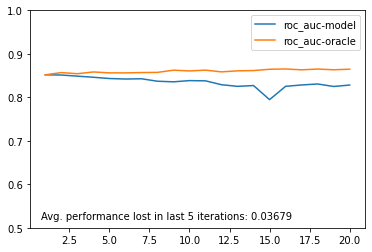

Sampling Bias: 0.03679


In [126]:
n_years = 20

model = lgbm.LGBMClassifier() # DecisionTreeClassifier(min_samples_leaf=40) LogisticRegression(max_iter=400)

sim = dal.Simulate_acceptance_loop("gmsc.csv", model, 0.1, 0.1, n_years, enc_features=False, rej_inf=None)#rinf.EMsemisupervised)
results_generator = sim.run()

metrics = None
for iteration in results_generator:
    print(f'Itteration: {iteration[0]}) Accepted: {iteration[1].count(True)} | Denied: {iteration[1].count(False)} - New train set size: {iteration[2]}')
    metrics = iteration[3]

last_n_years = 5
bias = h.measure_bias(metrics["oracle"]["holdout"]['roc_auc'], metrics["model"]["holdout"]['roc_auc'], last_n_years)
    
x = range(1, n_years + 1)
plt.plot(x, metrics["model"]["holdout"]['roc_auc'], label = 'roc_auc-model')
plt.plot(x, metrics["oracle"]["holdout"]['roc_auc'], label = 'roc_auc-oracle')
#plt.plot(x, results["holdout"]['precision'], label = 'precision')
#plt.plot(x, results["holdout"]['f1'], label = 'f1')
#plt.plot(x, results["holdout"]['accuracy'], label = 'accuracy')
plt.text(0.75, 0.52, f'Avg. performance lost in last {last_n_years} iterations: {round(bias, 5)}')
plt.legend()
plt.ylim([0.5, 1.0])
plt.show()


print(f'Sampling Bias: {round(bias, 5)}')

In [127]:
print(h.measure_bias(metrics["oracle"]["holdout"]['roc_auc'], metrics["model"]["holdout"]['roc_auc'], last_n_years))

0.036786960517788916


## Test importable Autoencoder

In [153]:
import autoencoder as aenc
import importlib
importlib.reload(aenc)

<module 'autoencoder' from 'c:\\Projects\\Information-Systems-Seminar\\reject-infer-autoencoder\\notebooks\\../src\\autoencoder.py'>

In [154]:
BATCH_SIZE = 300
EPOCHS = 40

dataset = aenc.CreditscoringDataset("gmsc.csv")      # load and prepare Dataset to Tensor
data_loader = aenc.DataLoader(                       # create Dataloader for batching
    dataset, 
    batch_size=BATCH_SIZE,
    shuffle=True
)

shape = [dataset.x.shape[1], 35, 20, 35, dataset.x.shape[1]]  # define shape of Autoencoder
net = aenc.Autoencoder(shape)
print(net)
net.to("cpu")

train_loss = aenc.train(net, data_loader, EPOCHS)               

plt.figure()
plt.plot(train_loss)
plt.title('Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

Autoencoder(
  (enc): ModuleList(
    (0): Linear(in_features=68, out_features=35, bias=True)
    (1): Linear(in_features=35, out_features=20, bias=True)
  )
  (dec): ModuleList(
    (0): Linear(in_features=20, out_features=35, bias=True)
    (1): Linear(in_features=35, out_features=68, bias=True)
  )
)
Epoch 1 of 40, Train Loss: 322110327159212160.000
Epoch 2 of 40, Train Loss: 441501354866535.188
Epoch 3 of 40, Train Loss: 390905341869101.875
Epoch 4 of 40, Train Loss: 319790912838335.062
Epoch 5 of 40, Train Loss: 435755005092940.438
Epoch 6 of 40, Train Loss: 361303593318491.688
Epoch 7 of 40, Train Loss: 328006464360020.062
Epoch 8 of 40, Train Loss: 438709091855100.188
Epoch 9 of 40, Train Loss: 327354301683436.875
Epoch 10 of 40, Train Loss: 297774880117286.188
Epoch 11 of 40, Train Loss: 250435153377616.250
Epoch 12 of 40, Train Loss: 247481953564030.094
Epoch 13 of 40, Train Loss: 270078153940869.719
Epoch 14 of 40, Train Loss: 225252344437928.125
Epoch 15 of 40, Train Loss: 2

KeyboardInterrupt: 

Itteration: 0) Accepted: 671 | Denied: 5404 - New train set size: (15671, 2)


c:\Projects\Information-Systems-Seminar\.venv\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Itteration: 1) Accepted: 631 | Denied: 5444 - New train set size: (16302, 2)


c:\Projects\Information-Systems-Seminar\.venv\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Projects\Information-Systems-Seminar\.venv\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Itteration: 2) Accepted: 647 | Denied: 5428 - New train set size: (16949, 2)


c:\Projects\Information-Systems-Seminar\.venv\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Projects\Information-Systems-Seminar\.venv\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Itteration: 3) Accepted: 663 | Denied: 5412 - New train set size: (17612, 2)


c:\Projects\Information-Systems-Seminar\.venv\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Projects\Information-Systems-Seminar\.venv\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Itteration: 4) Accepted: 604 | Denied: 5471 - New train set size: (18216, 2)


c:\Projects\Information-Systems-Seminar\.venv\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Projects\Information-Systems-Seminar\.venv\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Projects\Information-Systems-Seminar\.venv\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Itteration: 5) Accepted: 637 | Denied: 5438 - New train set size: (18853, 2)
Itteration: 6) Accepted: 643 | Denied: 5432 - New train set size: (19496, 2)


c:\Projects\Information-Systems-Seminar\.venv\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Projects\Information-Systems-Seminar\.venv\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Itteration: 7) Accepted: 633 | Denied: 5442 - New train set size: (20129, 2)
Itteration: 8) Accepted: 653 | Denied: 5422 - New train set size: (20782, 2)
Itteration: 9) Accepted: 667 | Denied: 5408 - New train set size: (21449, 2)
Itteration: 10) Accepted: 612 | Denied: 5463 - New train set size: (22061, 2)
Itteration: 11) Accepted: 589 | Denied: 5486 - New train set size: (22650, 2)
Itteration: 12) Accepted: 599 | Denied: 5476 - New train set size: (23249, 2)
Itteration: 13) Accepted: 545 | Denied: 5530 - New train set size: (23794, 2)


c:\Projects\Information-Systems-Seminar\.venv\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Projects\Information-Systems-Seminar\.venv\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Itteration: 14) Accepted: 646 | Denied: 5429 - New train set size: (24440, 2)


c:\Projects\Information-Systems-Seminar\.venv\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Itteration: 15) Accepted: 621 | Denied: 5454 - New train set size: (25061, 2)
Itteration: 16) Accepted: 627 | Denied: 5448 - New train set size: (25688, 2)


c:\Projects\Information-Systems-Seminar\.venv\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Itteration: 17) Accepted: 625 | Denied: 5450 - New train set size: (26313, 2)


c:\Projects\Information-Systems-Seminar\.venv\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Itteration: 18) Accepted: 605 | Denied: 5470 - New train set size: (26918, 2)


c:\Projects\Information-Systems-Seminar\.venv\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Projects\Information-Systems-Seminar\.venv\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Itteration: 19) Accepted: 606 | Denied: 5469 - New train set size: (27524, 2)


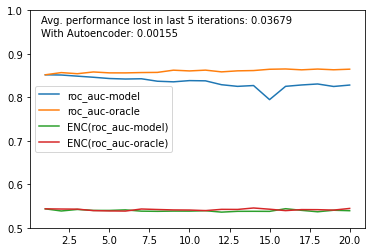

In [145]:
n_years = 20

sim = dal.Simulate_acceptance_loop("gmsc.csv", model, 0.1, 0.1, n_years, enc_features=True, encoder=net)#, rej_inf=rinf.EMsemisupervised)
results_generator = sim.run()

metrics2 = None
for iteration in results_generator:
    print(f'Itteration: {iteration[0]}) Accepted: {iteration[1].count(True)} | Denied: {iteration[1].count(False)} - New train set size: {iteration[2]}')
    metrics2 = iteration[3]

last_n_years = 5
bias2 = h.measure_bias(metrics2["oracle"]["holdout"]['roc_auc'], metrics2["model"]["holdout"]['roc_auc'], last_n_years)
    
x = range(1, n_years + 1)
plt.plot(x, metrics["model"]["holdout"]['roc_auc'], label = 'roc_auc-model')
plt.plot(x, metrics["oracle"]["holdout"]['roc_auc'], label = 'roc_auc-oracle')
plt.plot(x, metrics2["model"]["holdout"]['roc_auc'], label = 'ENC(roc_auc-model)')
plt.plot(x, metrics2["oracle"]["holdout"]['roc_auc'], label = 'ENC(roc_auc-oracle)')
plt.text(0.75, 0.97, f'Avg. performance lost in last {last_n_years} iterations: {round(bias, 5)}')
plt.text(0.75, 0.94, f'With Autoencoder: {round(bias2, 5)}')
plt.legend()
plt.ylim([0.5, 1.0])
plt.show()